# 第１４章 ディープラーニングの手解き

In [1]:
import datetime
import statsmodels.api as sm
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
tf.random.set_seed(42)
np.random.seed(42)

from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import importlib.util
import sys
# japanize-matplotlib が未インストールなら pip install
if importlib.util.find_spec("japanize_matplotlib") is None:
  !pip install japanize-matplotlib
# 必要なライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2025-06-12 19:09:07.097280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0
GPU Available: []


In [2]:
# CH12のデータのロード from GitHubのrawデータURL
u1 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_train.csv"
u2 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_val.csv"
u3 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_test.csv"
# データの読み込み
train_df = pd.read_csv(u1)
val_df = pd.read_csv(u2)
test_df = pd.read_csv(u3)
train_df.head()
from CH13 import DataWindow,BaselineModel,model_predict,plot_model_prediction

2.17.0
GPU Available: []


前章ではDataWindowクラスを実装しました。

本章では線形モデルとディープニューラルネットワークを実装します。

**・線形モデル**

隠れそうがない特殊なニューラルネットワーク

このモデルは、目的変数の予測値を出力させるために各入力変数の重みを計算する

**・ディープニューラルネットワーク**

隠れ層が少なくとも一つあり、特徴量と目的変数の間の非線形関係をモデル化できる


**14.1 線形モデルを実装する**

線形モデルはディープラーニングで実装できるアーキテクチャのうち最も簡単なもの。

従来の線形回帰と同じように、各入力特徴量に単に重みを割り当てて、それらを統合して目的変数の予測値を出力します。

例としてシングルステップモデルを考える。

このデータセットにはtemp(気温)、clouds_all(雲量)、traffic_volime(交通量)、day_sin、day_cosの五つの特徴量があります。

これらの全ての特徴量でそれぞれの重みを計算し、次の時間ステップの予測値を出力する

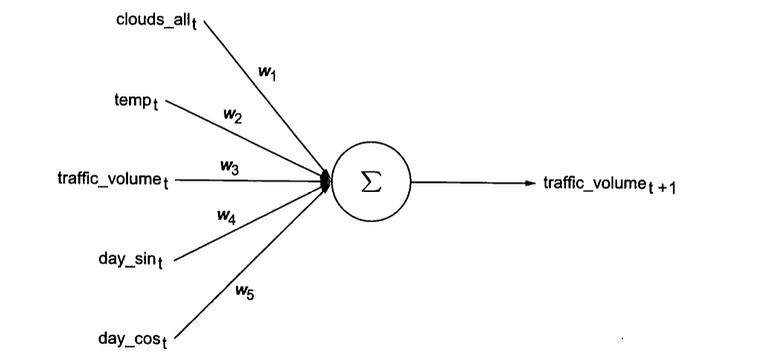

これを数式で表すと

$$
traffic_volime_{t+1}=w_1x_{1,t}+w_2x_{2,t}+w_3x_{3,t}+w_4_{4,t}+w_5_{5,t}
$$

ここで$x_1$はclouds_all、$x_2$はtemp、$x_3$はtraffic_volume、$x_4$はday_sin、$x_5$はday_cosを表す。   


単純な多変量線形回帰となっている。

*14.1.1 シングルステップモデルの線形モデルを実装*

In [3]:
def compile_and_fit(model, window, patience=5, max_epochs=100):
    """
    モデルをコンパイルし、早期終了（EarlyStopping）を用いて訓練する。

    Parameters:
    -----------
    model : tf.keras.Model
        訓練対象のKerasモデル。
    
    window : DataWindowオブジェクト
        入力データとラベルデータを提供するデータウィンドウ。window.train や window.val を含む。
    
    patience : int
        'val_loss'（検証損失）の改善がこのエポック数続けて見られない場合に訓練を停止する。
    
    max_epochs : int
        訓練の最大エポック数。早期終了が発動しなければこの回数まで訓練が続く。

    Returns:
    --------
    history : tf.keras.callbacks.History
        モデル訓練の履歴。各エポックの損失やメトリクスが含まれる。
    """

    # 検証損失が改善しない場合に訓練を打ち切るためのコールバックを設定
    early_stopping = EarlyStopping(
        monitor='val_loss',  # 監視対象は検証損失
        patience=patience,   # 何エポック改善がなければ停止するか
        mode='min'           # 最小化を目指す（損失を減らす）
    )

    # モデルのコンパイル
    model.compile(
        loss=MeanSquaredError(),          # 損失関数：平均二乗誤差（MSE）
        optimizer=Adam(),                 # 最適化手法：Adam（自動調整学習率付き勾配法）
        metrics=[MeanAbsoluteError()]     # 評価指標：平均絶対誤差（MAE）
    )

    # モデルの訓練を実行
    history = model.fit(
        window.train,                     # 訓練データ
        epochs=max_epochs,                # 最大エポック数
        validation_data=window.val,       # 検証データ
        callbacks=[early_stopping]        # コールバックに早期終了を指定
    )

    return history  # 訓練履歴を返す

In [4]:
ss_val_performance={'last': (0.0133, 0.0831)}
ss_test_performance={'last': (0.0125, 0.0813)}
ms_val_performance={'last': (0.1498, 0.309),
  'mean': (0.0797, 0.2462),
  'repeat': (0.0225, 0.0815)}
ms_test_performance={'last': (0.1426, 0.3021),
  'mean': (0.0739, 0.237),
  'repeat': (0.017, 0.0676)}

mo_val_performance={'last': (0.0069, 0.0482)}
mo_test_performance={'last': (0.0064, 0.047)}

In [5]:
# DataWindow のインスタンス化
w_ss = DataWindow(input_width=1,label_width=1,shift=1,stride=1,
    train_df=train_df,val_df=val_df,test_df=test_df,
    label_columns=['traffic_volume'])

In [6]:
# 単層の線形モデルを構築（多変量線形回帰に相当）
ss_linear = Sequential([Dense(units=1)])
# モデルをコンパイル・訓練（EarlyStoppingつき）
# 損失: MeanSquaredError, 最適化: Adam, 評価指標: MeanAbsoluteError
history = compile_and_fit(ss_linear, w_ss)

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4074 - mean_absolute_error: 1.0699 - val_loss: 0.2204 - val_mean_absolute_error: 0.3759
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1943 - mean_absolute_error: 0.3488 - val_loss: 0.0865 - val_mean_absolute_error: 0.2363
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0874 - mean_absolute_error: 0.2360 - val_loss: 0.0676 - val_mean_absolute_error: 0.2115
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0636 - mean_absolute_error: 0.2013 - val_loss: 0.0483 - val_mean_absolute_error: 0.1787
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0445 - mean_absolute_error: 0.1668 - val_loss: 0.0331 - val_mean_absolute_error: 0.1466
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0302 - mean_absolute_error: 0.1348 - val_loss: 0.0229 - val_mean_absolute_error: 0.1195
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1

例)

Input:[batch_size, input_width, num_features] :3次元

Single Step Model:[32,1,5]

Denseは最後の次元(この場合はnum_features)に作用する

Output:[batch_size, label_width, 1]：3次元

例)
ex. Single Step Model:[32,1,1]

$$
X[b,t,i] → y[b,t+1,i] = \sum_{i=1}^{n}X[b,t,i]w_i + w_0
$$

In [7]:
# 評価スコアを辞書に保存
val_loss, val_mae = ss_linear.evaluate(w_ss.val, verbose=0)
test_loss, test_mae = ss_linear.evaluate(w_ss.test, verbose=0)
ss_val_performance["Linear"] = (round(val_loss,4), round(val_mae,4))
ss_test_performance["Linear"] = (round(test_loss,4),round(test_mae,4))
ss_val_performance,ss_test_performance

({'last': (0.0133, 0.0831), 'Linear': (0.009, 0.0686)},
 {'last': (0.0125, 0.0813), 'Linear': (0.0083, 0.0659)})

**14.1.2 マルチステップの線形モデルを実装**

このモデルはそれぞれの特徴量について24時間分のデータを取得し、それらを一つの層で結合して次の24時間分の予測値を出力します。
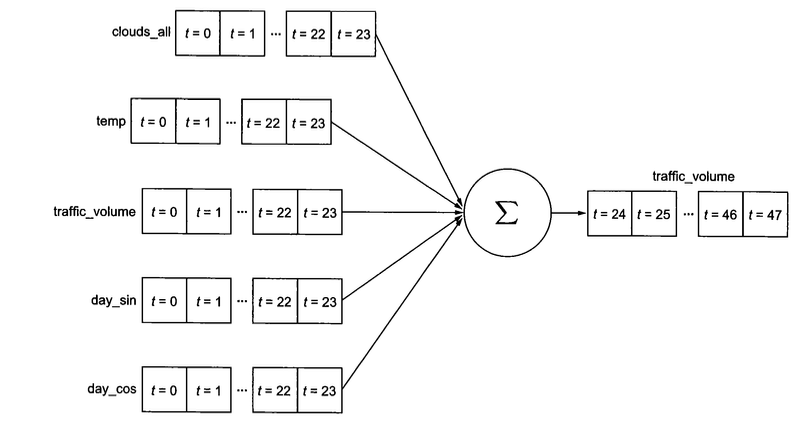

In [8]:
w_ms = DataWindow(input_width=24,label_width=24,shift=24,stride=1,
    train_df=train_df,val_df=val_df,test_df=test_df,
    label_columns=['traffic_volume'])


ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, w_ms)

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1444 - mean_absolute_error: 0.3138 - val_loss: 0.0453 - val_mean_absolute_error: 0.1793
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0356 - mean_absolute_error: 0.1556 - val_loss: 0.0249 - val_mean_absolute_error: 0.1232
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0212 - mean_absolute_error: 0.1113 - val_loss: 0.0207 - val_mean_absolute_error: 0.1070
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0181 - mean_absolute_error: 0.0983 - val_loss: 0.0195 - val_mean_absolute_error: 0.1003
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.0927 - val_loss: 0.0187 - val_mean_absolute_error: 0.0957
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0166 - mean_absolute_error: 0.0894 - val_loss: 0.0184 - val_mean_absolute_error: 0.0927
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - mean_absolute_error: 0.0

例)

Input:[batch_size, input_width, num_features] :3次元

ex. Single Step Model:[32,24,5]

Output:[batch_size, label_width, 1]：3次元

ex. Single Step Model:[32,24,1]

$$
X[b,t,i] → y[b,t+24,i] = \sum_{i=1}^{n}X[b,t,i]w_i + w_0 　　　i=1,・・・,24
$$

In [9]:
val_loss, val_mae = ms_linear.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = ms_linear.evaluate(w_ms.test, verbose=0)
ms_val_performance["Linear"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["Linear"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

({'last': (0.1498, 0.309),
  'mean': (0.0797, 0.2462),
  'repeat': (0.0225, 0.0815),
  'Linear': (0.018, 0.0881)},
 {'last': (0.1426, 0.3021),
  'mean': (0.0739, 0.237),
  'repeat': (0.017, 0.0676),
  'Linear': (0.0141, 0.0767)})

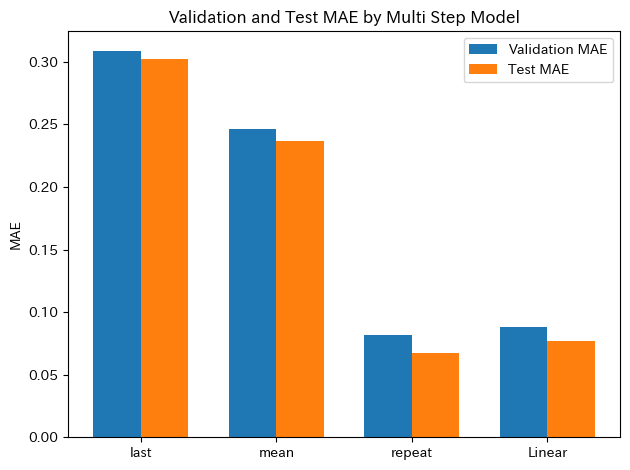

In [10]:
# MAE（1番目の指標）を抽出
labels = list(ms_val_performance.keys())
val_mae = [ms_val_performance[k][1] for k in labels]
test_mae = [ms_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Multi Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

$$
X[b,t,i] → y[b,t+24,i] = \sum_{i=1}^{n}X[b,t,i]w_i + w_0 　　　i=1,・・・,24
$$

この計算において、24個の出力タイムステップすべてに対して同じ重みwとバイアスw0が使用されるという点です。この結果24時間周期を完全には把握できていないため、repeatモデルに負けている。

次に、各出力タイムステップに対して異なる線形変換を学習することで、モデルの柔軟性を高めることを目指した「時刻依存（Time-Dependent）線形モデル」を見ていきます

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Concatenate, Reshape

def TD_linear_model(input_shape):
    inputs = Input(shape=input_shape)
    outputs = []

    for t in range(input_shape[0]):
        x_t = Lambda(lambda x, t=t: x[:, t])(inputs)  # クロージャで t を固定
        #24個の Lambda が、t=0,1,2,...23 それぞれに対応してくれる
        y_t = Dense(1)(x_t)                           # 各時刻に独立な Dense
        outputs.append(y_t)

    conc = Concatenate(axis=1)(outputs)               # [batch, time]
    final = Reshape((input_shape[0], 1))(conc)        # [batch, time, 1]

    return Model(inputs=inputs, outputs=final)

# データセットの input_shape を取得
input_shape = w_ms.train.element_spec[0].shape[1:]  # 例：(24, 5)

# モデルの構築
ms_linear = TD_linear_model(input_shape)

#　モデルの訓練
history = compile_and_fit(ms_linear, w_ms)

# 評価スコアを辞書に保存
val_loss, val_mae = ms_linear.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = ms_linear.evaluate(w_ms.test, verbose=0)
ms_val_performance["TD-Linear"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["TD-Linear"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5841 - mean_absolute_error: 0.5930 - val_loss: 0.2229 - val_mean_absolute_error: 0.3607
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1705 - mean_absolute_error: 0.3153 - val_loss: 0.1040 - val_mean_absolute_error: 0.2448
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0847 - mean_absolute_error: 0.2201 - val_loss: 0.0585 - val_mean_absolute_error: 0.1809
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0483 - mean_absolute_error: 0.1634 - val_loss: 0.0369 - val_mean_absolute_error: 0.1408
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0308 - mean_absolute_error: 0.1278 - val_loss: 0.0268 - val_mean_absolute_error: 0.1170
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.1073 - val_loss: 0.0222 - val_mean_absolute_error: 0.1037
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0

({'last': (0.1498, 0.309),
  'mean': (0.0797, 0.2462),
  'repeat': (0.0225, 0.0815),
  'Linear': (0.018, 0.0881),
  'TD-Linear': (0.0181, 0.0886)},
 {'last': (0.1426, 0.3021),
  'mean': (0.0739, 0.237),
  'repeat': (0.017, 0.0676),
  'Linear': (0.0141, 0.0767),
  'TD-Linear': (0.0141, 0.077)})

$$
X[b,t,i] → y[b,t+24,i] = \sum_{i=1}^{n}X[b,t,i]w_{i,t} + w_0 i=1,・・・,24
$$

係数$w_{i,t}$は24時間それぞれ異なる

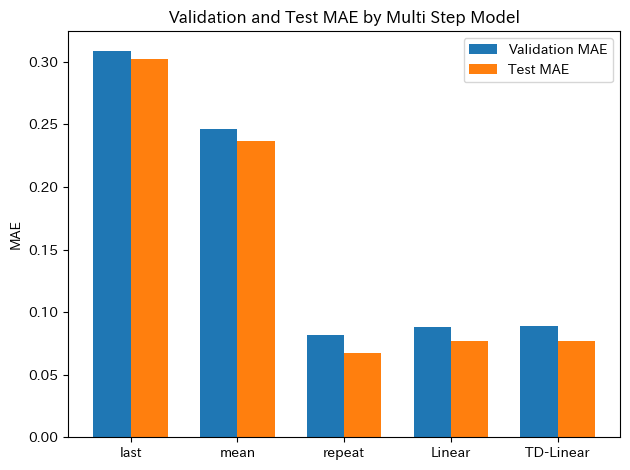

In [12]:
# MAE（1番目の指標）を抽出
labels = list(ms_val_performance.keys())
val_mae = [ms_val_performance[k][1] for k in labels]
test_mae = [ms_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Multi Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

性能が低下していることがわかる。

このモデルは、各出力タイムステップが独自の線形変換を学習するため、より柔軟です。しかし、その柔軟性を活かすにはより多くの訓練データが必要となります。

モデルの複雑さ（パラメータ数）が増すと、より複雑なパターンを捉える能力が向上しますが、同時に十分なデータがないと効果的に訓練することが難しくなり、汎化性能が低下する可能性があります。


3番目に検討するのは、入力シーケンス全体を一度平坦化（Flatten）し、単一の大きなDense層で全タイムステップの予測を同時に行う「Full-Linear」モデルです。

In [13]:
# データセットの input_shape を取得
input_shape = w_ms.train.element_spec[0].shape[1:]  # 例：(24, 5)
label_width=24

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape

ms_linear = Sequential([
    Flatten(input_shape=input_shape),  # 24×5 = 120
    Dense(label_width),                                # 予測ステップ数に応じた出力
    Reshape((label_width, 1))                          # [batch, 24, 1] などに変形
])


#　モデルの訓練
history = compile_and_fit(ms_linear, w_ms)

# 評価スコアを辞書に保存
val_loss, val_mae = ms_linear.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = ms_linear.evaluate(w_ms.test, verbose=0)
ms_val_performance["Full-Linear"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["Full-Linear"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1551 - mean_absolute_error: 0.2713 - val_loss: 0.0350 - val_mean_absolute_error: 0.1427
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0286 - mean_absolute_error: 0.1279 - val_loss: 0.0240 - val_mean_absolute_error: 0.1135
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0205 - mean_absolute_error: 0.1045 - val_loss: 0.0197 - val_mean_absolute_error: 0.0992
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0174 - mean_absolute_error: 0.0934 - val_loss: 0.0181 - val_mean_absolute_error: 0.0933
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0883 - val_loss: 0.0171 - val_mean_absolute_error: 0.0890
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0157 - mean_absolute_error: 0.0860 - val_loss: 0.0173 - val_mean_absolute_error: 0.0901
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0155 - mean_absolute_error: 0.0

({'last': (0.1498, 0.309),
  'mean': (0.0797, 0.2462),
  'repeat': (0.0225, 0.0815),
  'Linear': (0.018, 0.0881),
  'TD-Linear': (0.0181, 0.0886),
  'Full-Linear': (0.016, 0.0836)},
 {'last': (0.1426, 0.3021),
  'mean': (0.0739, 0.237),
  'repeat': (0.017, 0.0676),
  'Linear': (0.0141, 0.0767),
  'TD-Linear': (0.0141, 0.077),
  'Full-Linear': (0.0126, 0.0723)})

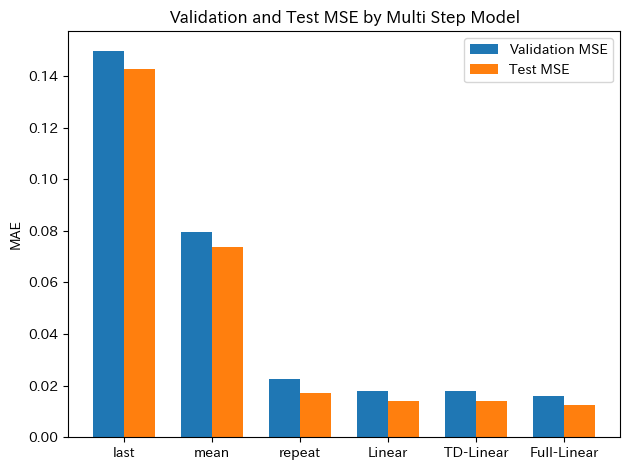

In [14]:
# MAE（1番目の指標）を抽出
labels = list(ms_val_performance.keys())
val_mae = [ms_val_performance[k][0] for k in labels]
test_mae = [ms_test_performance[k][0] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MSE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MSE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MSE by Multi Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

これまでに見てきた3つの線形モデル、Linear、TD-Linear、Full-Linearを比較し、それぞれの特徴と性能について考察します。

Full-Linear（Flatten → Dense(label_width)） が他の全線形モデルよりもベスト


Linearモデル: 最も基本的なアプローチで、全出力タイムステップに対して単一の線形変換（共有された重み）を適用します。単純さゆえに表現力に乏しく、周期性などの複雑なパターンを捉えにくい傾向があります。

TD-Linearモデル: 各出力タイムステップに対して独立した線形変換を学習します。柔軟性は増しますが、パラメータ数が大幅に増加し、十分なデータがないと性能が低下する可能性があります。

Full-Linearモデル: 入力シーケンス全体を平坦化し、単一の大きな線形層で全出力タイムステップを予測します。時間的順序情報を一度ベクトルに集約することで、入力全体のグローバルなパターンから予測を行います。多くの場合、3つの線形モデルの中で最も良い性能を示しました。

**14.1.3 多出力の線形モデルの実装**

全ての特徴量についてt=0時点での値を取得し、それらを一つの層で結合し、次の時間ステップの気温と交通量の予測値を出力します。

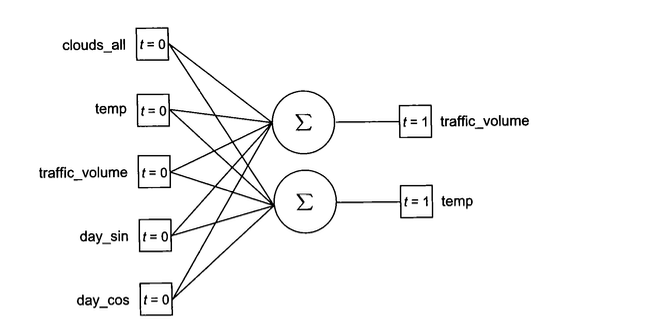

In [15]:
w_mo = DataWindow(input_width=1,label_width=1,shift=1,stride=1,
    train_df=train_df,val_df=val_df,test_df=test_df,
    label_columns=['temp','traffic_volume'])

mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, w_mo)

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9612 - mean_absolute_error: 0.8446 - val_loss: 0.2859 - val_mean_absolute_error: 0.4500
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1936 - mean_absolute_error: 0.3733 - val_loss: 0.1265 - val_mean_absolute_error: 0.3058
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0988 - mean_absolute_error: 0.2709 - val_loss: 0.0704 - val_mean_absolute_error: 0.2270
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0562 - mean_absolute_error: 0.2023 - val_loss: 0.0416 - val_mean_absolute_error: 0.1734
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0342 - mean_absolute_error: 0.1546 - val_loss: 0.0270 - val_mean_absolute_error: 0.1370
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0231 - mean_absolute_error: 0.1235 - val_loss: 0.0192 - val_mean_absolute_error: 0.1132
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.1

In [16]:
# 評価スコアを辞書に保存
val_loss, val_mae = mo_linear.evaluate(w_mo.val, verbose=0)
test_loss, test_mae = mo_linear.evaluate(w_mo.test, verbose=0)
mo_val_performance["Linear"] = (round(val_loss,4), round(val_mae,4))
mo_test_performance["Linear"] = (round(test_loss,4),round(test_mae,4))
mo_val_performance,mo_test_performance

({'last': (0.0069, 0.0482), 'Linear': (0.0046, 0.0378)},
 {'last': (0.0064, 0.047), 'Linear': (0.0043, 0.0359)})

**14.2 ディープニューラルネットワーク(DNN)を実装する**

ニューラルネットワークに隠れ層の追加とデータに内在する非線形関数を細くするために、非線形の活性化関数の導入

線形モデルには隠れ層がなく、あったのは入力層と出力層のみ。
DNNでは入力層と出力層の間に隠れ層を追加する。

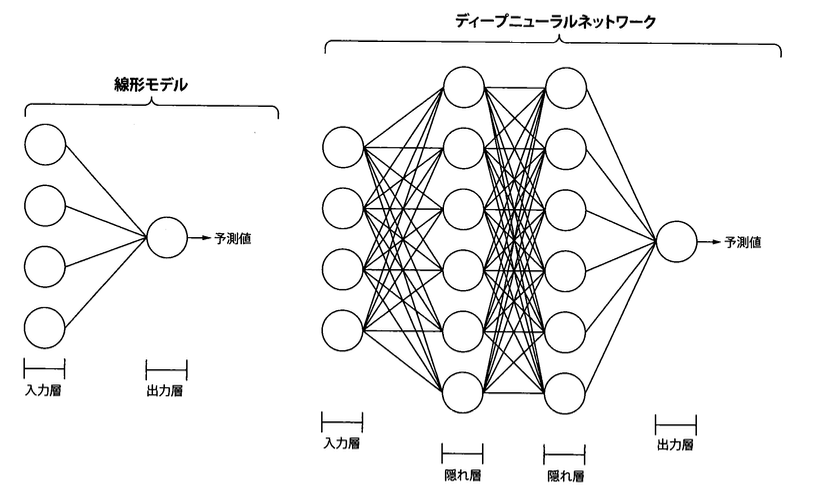


ネットワークへ層を追加すればモデルをより長い時間にわたって訓練することになるため、その分学習効率も上がります。

ニューロンにはそれぞれ活性化関数があり、ニューロンの個数はKerasのDense層に引数として渡されるunitsパラメータの値と同じ。

*活性化関数*

ニューラルネットワークの各ニューロンにあり、入力データから出力を生成する役割を持つ。

線形の活性化関数を使う場合、モデル化できるのは線形関係。

非線形関係をモデル化するには、非線形の活性化関数を使う。

この例ではReLU関数を用いる。

$$
f(x) = x^+= max(0,x)      
$$

この関数は入力の正の部分を返すか、0を返す。

また、勾配の伝播が円滑になり、計算が効率化され、特徴量の尺度の影響を受けない。

14.2.1 DNNをシングルステップモデルとして実装


In [17]:
ss_dnn = Sequential([
    Dense(units=32, activation='relu'),#隠れ層(非線形変換)
    Dense(units=1)#出力層(線形変換)
])

history = compile_and_fit(ss_dnn, w_ss)

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0990 - mean_absolute_error: 0.2248 - val_loss: 0.0079 - val_mean_absolute_error: 0.0657
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0636 - val_loss: 0.0064 - val_mean_absolute_error: 0.0589
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0591 - val_loss: 0.0056 - val_mean_absolute_error: 0.0556
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0566 - val_loss: 0.0049 - val_mean_absolute_error: 0.0532
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0053 - mean_absolute_error: 0.0539 - val_loss: 0.0042 - val_mean_absolute_error: 0.0493
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0047 - mean_absolute_error: 0.0509 - val_loss: 0.0039 - val_mean_absolute_error: 0.0486
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - mean_absolute_error: 0.0

例)

input_width = 1, num_features = 5

入力層 → 隠れ層:[batch,1,5] → [batch,1,32] (ReLu適用)

隠れ層 → 出力層:[batch,1,32] → [batch,1,1,] (Dense適用)

In [18]:
# 評価スコアを辞書に保存
val_loss, val_mae = ss_dnn.evaluate(w_ss.val, verbose=0)
test_loss, test_mae = ss_dnn.evaluate(w_ss.test, verbose=0)
ss_val_performance["DNN"] = (round(val_loss,4), round(val_mae,4))
ss_test_performance["DNN"] = (round(test_loss,4),round(test_mae,4))
ss_val_performance,ss_test_performance

({'last': (0.0133, 0.0831), 'Linear': (0.009, 0.0686), 'DNN': (0.002, 0.0328)},
 {'last': (0.0125, 0.0813),
  'Linear': (0.0083, 0.0659),
  'DNN': (0.0018, 0.0318)})

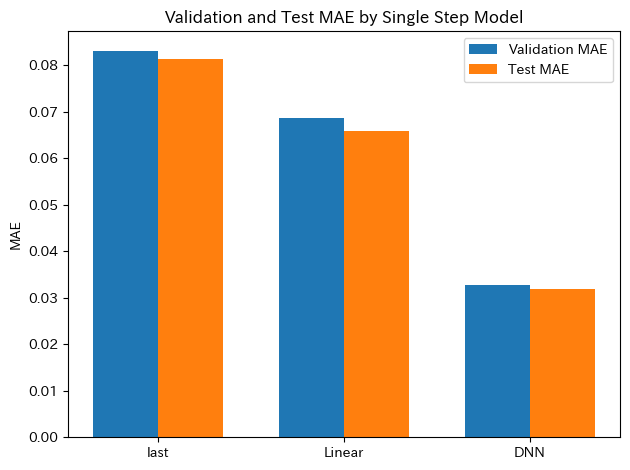

In [19]:
# MAE（1番目の指標）を抽出
labels = list(ss_val_performance.keys())
val_mae = [ss_val_performance[k][1] for k in labels]
test_mae = [ss_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Single Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

14.2.2 DNNをマルチステップモデルとして実装

In [20]:
ms_dnn = Sequential([
    Dense(32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),#各時間ステップの隠れ表現から、そのステップに対応する単一の予測値を生成。初期予測はゼロ。
])

history = compile_and_fit(ms_dnn,w_ms)

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0968 - mean_absolute_error: 0.2320 - val_loss: 0.0179 - val_mean_absolute_error: 0.0883
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0822 - val_loss: 0.0172 - val_mean_absolute_error: 0.0870
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - mean_absolute_error: 0.0811 - val_loss: 0.0166 - val_mean_absolute_error: 0.0855
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0145 - mean_absolute_error: 0.0798 - val_loss: 0.0163 - val_mean_absolute_error: 0.0838
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0142 - mean_absolute_error: 0.0786 - val_loss: 0.0160 - val_mean_absolute_error: 0.0829
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0140 - mean_absolute_error: 0.0780 - val_loss: 0.0157 - val_mean_absolute_error: 0.0822
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0138 - mean_absolute_error: 0.0

In [21]:
# 評価スコアを辞書に保存
val_loss, val_mae = ms_dnn.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = ms_dnn.evaluate(w_ms.test, verbose=0)
ms_val_performance["DNN"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["DNN"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

({'last': (0.1498, 0.309),
  'mean': (0.0797, 0.2462),
  'repeat': (0.0225, 0.0815),
  'Linear': (0.018, 0.0881),
  'TD-Linear': (0.0181, 0.0886),
  'Full-Linear': (0.016, 0.0836),
  'DNN': (0.0138, 0.0763)},
 {'last': (0.1426, 0.3021),
  'mean': (0.0739, 0.237),
  'repeat': (0.017, 0.0676),
  'Linear': (0.0141, 0.0767),
  'TD-Linear': (0.0141, 0.077),
  'Full-Linear': (0.0126, 0.0723),
  'DNN': (0.0101, 0.0643)})

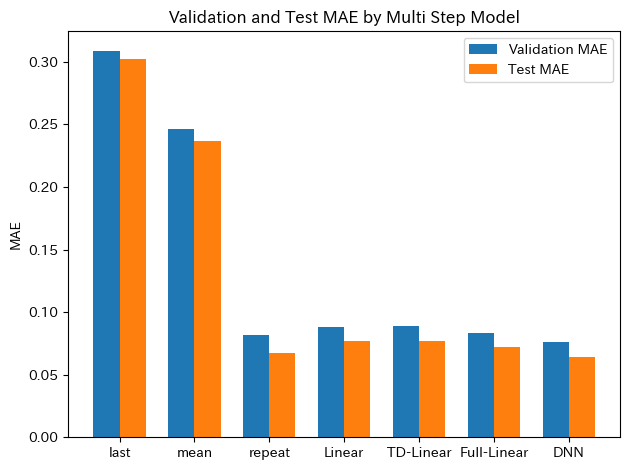

In [22]:
# MAE（1番目の指標）を抽出
labels = list(ms_val_performance.keys())
val_mae = [ms_val_performance[k][1] for k in labels]
test_mae = [ms_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Multi Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
# データセットの input_shape を取得
input_shape = w_ms.train.element_spec[0].shape[1:]  # 例：(24, 5)
label_width=24

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape

ms_dnn = Sequential([
    Flatten(input_shape=input_shape),      # [batch, input_width, 5] → [batch, 120]
    Dense(32, activation='relu'),          # [batch, 120] → [batch, 32]
    Dense(32, activation='relu'),          # [batch, 32] → [batch, 32]
    Dense(label_width, kernel_initializer=tf.initializers.zeros),  # [batch, label_width]
    Reshape((label_width, 1))              # [batch, label_width] → [batch, label_width, 1]
])

#　モデルの訓練
history = compile_and_fit(ms_dnn, w_ms)

# 評価スコアを辞書に保存
val_loss, val_mae = ms_dnn.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = ms_dnn.evaluate(w_ms.test, verbose=0)
ms_val_performance["Full-DNN2"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["Full-DNN2"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0681 - mean_absolute_error: 0.1882 - val_loss: 0.0198 - val_mean_absolute_error: 0.1019
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0169 - mean_absolute_error: 0.0936 - val_loss: 0.0168 - val_mean_absolute_error: 0.0909
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - mean_absolute_error: 0.0843 - val_loss: 0.0157 - val_mean_absolute_error: 0.0869
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0139 - mean_absolute_error: 0.0812 - val_loss: 0.0155 - val_mean_absolute_error: 0.0861
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0134 - mean_absolute_error: 0.0797 - val_loss: 0.0147 - val_mean_absolute_error: 0.0830
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0768 - val_loss: 0.0139 - val_mean_absolute_error: 0.0794
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0

({'last': (0.1498, 0.309),
  'mean': (0.0797, 0.2462),
  'repeat': (0.0225, 0.0815),
  'Linear': (0.018, 0.0881),
  'TD-Linear': (0.0181, 0.0886),
  'Full-Linear': (0.016, 0.0836),
  'DNN': (0.0138, 0.0763),
  'Full-DNN2': (0.0091, 0.0641)},
 {'last': (0.1426, 0.3021),
  'mean': (0.0739, 0.237),
  'repeat': (0.017, 0.0676),
  'Linear': (0.0141, 0.0767),
  'TD-Linear': (0.0141, 0.077),
  'Full-Linear': (0.0126, 0.0723),
  'DNN': (0.0101, 0.0643),
  'Full-DNN2': (0.0067, 0.0546)})

この2層化により、非線形構造や高次の特徴組み合わせへの感度が上がり、精度向
上が期待できます。

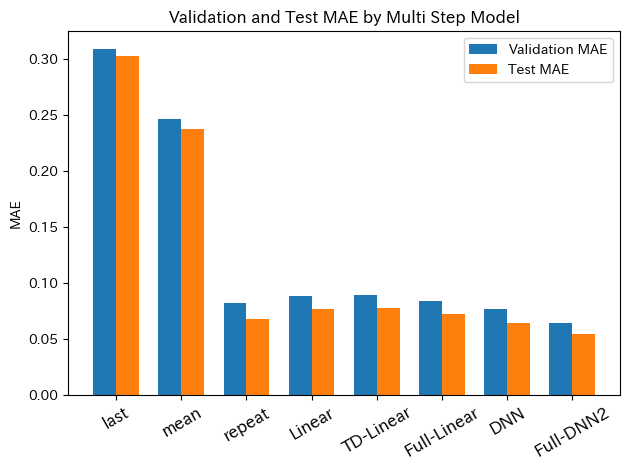

In [24]:
# MAE（1番目の指標）を抽出
labels = list(ms_val_performance.keys())
val_mae = [ms_val_performance[k][1] for k in labels]
test_mae = [ms_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Multi Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels, fontsize=12, rotation=30)  # フォントサイズを小さくし、斜めに表示
ax.legend()
plt.tight_layout()
plt.show()

Full-DNN2が最も低いMAEを指名していることから予測精度が高いことがわかる。

14.2.3 DNNを多出力モデルとして実装

In [25]:
mo_dnn = Sequential([
    Dense(units=32, activation='relu'),
    #入力を受け取り、ReLU活性化関数で32ユニットに変換（非線形処理）
    Dense(units=32, activation='relu'),
    #中間層でもう一度ReLUで非線形変換を加え、表現力を強化
    Dense(units=2)#ユニット数は2で、2次元の連続値を同時に出力
])

history = compile_and_fit(mo_dnn, w_mo)

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0706 - mean_absolute_error: 0.1797 - val_loss: 0.0042 - val_mean_absolute_error: 0.0389
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - mean_absolute_error: 0.0391 - val_loss: 0.0031 - val_mean_absolute_error: 0.0339
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0034 - mean_absolute_error: 0.0354 - val_loss: 0.0026 - val_mean_absolute_error: 0.0323
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0029 - mean_absolute_error: 0.0334 - val_loss: 0.0022 - val_mean_absolute_error: 0.0296
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - mean_absolute_error: 0.0320 - val_loss: 0.0020 - val_mean_absolute_error: 0.0284
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0309 - val_loss: 0.0018 - val_mean_absolute_error: 0.0275
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022 - mean_absolute_error: 0.0

In [26]:
# 評価スコアを辞書に保存
val_loss, val_mae = mo_dnn.evaluate(w_mo.val, verbose=0)
test_loss, test_mae = mo_dnn.evaluate(w_mo.test, verbose=0)
mo_val_performance["DNN"] = (round(val_loss,4), round(val_mae,4))
mo_test_performance["DNN"] = (round(test_loss,4),round(test_mae,4))
mo_val_performance,mo_test_performance

({'last': (0.0069, 0.0482),
  'Linear': (0.0046, 0.0378),
  'DNN': (0.001, 0.0201)},
 {'last': (0.0064, 0.047),
  'Linear': (0.0043, 0.0359),
  'DNN': (0.0008, 0.0179)})

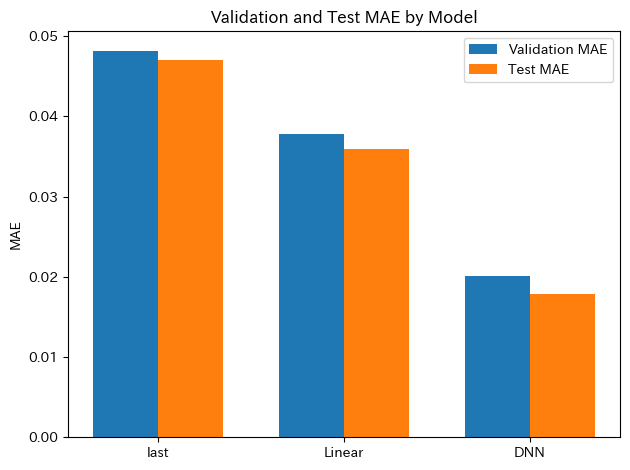

In [27]:
# MAE（1番目の指標）を抽出
labels = list(mo_val_performance.keys())
val_mae = [mo_val_performance[k][1] for k in labels]
test_mae = [mo_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()